In [1]:
import dynamo as dyn
import matplotlib.pyplot as plt
import numpy as np

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/ken67/anaconda3/envs/grn-2023/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
from dynamo.tools.graph_calculus import GraphVectorField, graphize_velocity_coopt, gradient

In [3]:
from tangent_space import corr_kernel, cos_corr, density_corrected_transition_matrix

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
skip_propagation = False
skip_stationary_distribution = False

In [6]:
adata = dyn.read('../data/simulation/neurogenesis_tau5_rep10.h5ad')
adata

AnnData object with n_obs × n_vars = 5000 × 12
    obs: 'trajectory', 'time', 'cell_type'
    var: 'a', 'K', 'n', 'gamma', 'use_for_pca'
    uns: 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca', 'X_raw', 'velocity_pca', 'velocity_raw'
    layers: 'total', 'velocity_T'

In [7]:
dyn.tl.neighbors(adata, basis='raw', n_neighbors=200)

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:raw
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 5000 × 12
    obs: 'trajectory', 'time', 'cell_type'
    var: 'a', 'K', 'n', 'gamma', 'use_for_pca'
    uns: 'PCs', 'explained_variance_ratio_', 'pca_mean', 'neighbors'
    obsm: 'X_pca', 'X_raw', 'velocity_pca', 'velocity_raw'
    layers: 'total', 'velocity_T'
    obsp: 'distances', 'connectivities'

(-107.0562671661377,
 128.87658729553223,
 -92.72346267700195,
 106.78542861938476)

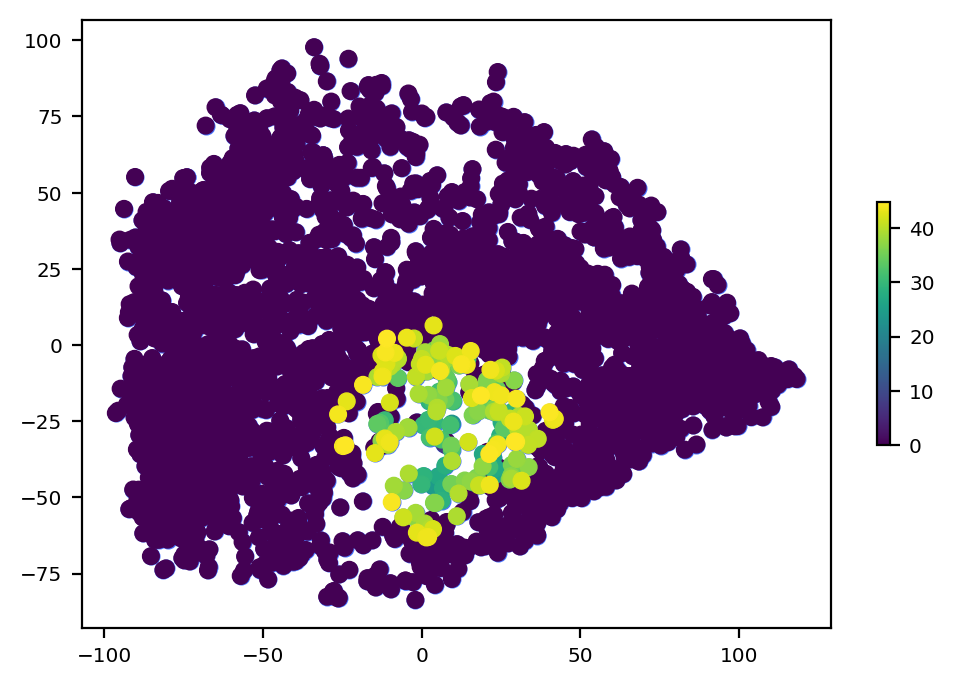

In [8]:
cell = dyn.tl.sample(adata.n_obs, 1)[0]

dist = adata.obsp['distances'].A[cell]
dyn.pl.zscatter(adata, basis='pca')
dyn.pl.zscatter(adata, basis='pca', color=dist, cmap='viridis')
plt.axis('on')

In [9]:
X = adata.layers['total']
V = adata.layers['velocity_T']
X_emb = adata.obsm['X_pca']
nbrs_idx = adata.uns['neighbors']['indices']

# Correlation Kernel

In [10]:
P = corr_kernel(X, V, nbrs_idx, corr_func=cos_corr)
P_dc = density_corrected_transition_matrix(P).A
gvf = dyn.tl.GraphVectorField(P)

V_cos = gvf.project_velocity(X, norm_dist=False, correct_density=True)
adata.obsm['velocity_cos'] = V_cos
adata.obs['velocity_cos'] = np.linalg.norm(V_cos, axis=1)

V_cos_nodc = gvf.project_velocity(X, norm_dist=False, correct_density=False)
adata.obsm['velocity_cos_nodc'] = V_cos_nodc
adata.obs['velocity_cos_nodc'] = np.linalg.norm(V_cos_nodc, axis=1)

adata.obs['velocity_pca'] = np.linalg.norm(adata.obsm['velocity_pca'], axis=1)

|-----> Neither edge weight nor length matrix is provided. Inferring adjacency matrix from `F`.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.7533s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6187s]


Text(0.5, 1.0, 'ground truth')

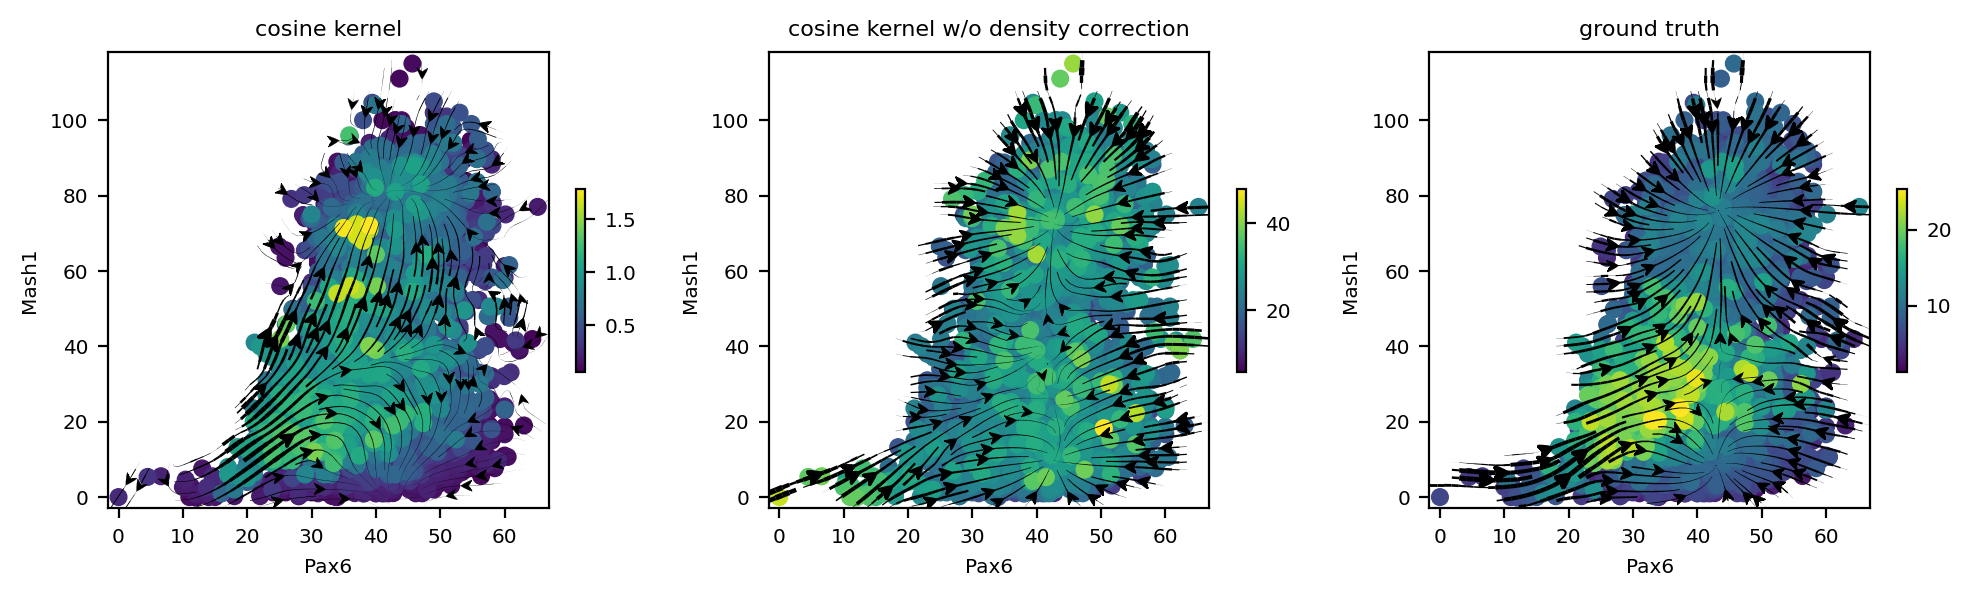

In [11]:
genes = ['Pax6', 'Mash1']
dims = [np.where(adata.var.index==g)[0][0] for g in genes]

plt.figure(figsize=(12, 3))

plt.subplot(131)
dyn.pl.zscatter(adata, basis='raw', color='velocity_cos', cmap='viridis', dims=dims, axis_off=False)
dyn.pl.zstreamline(adata, basis='raw', v_basis='cos', dims=dims)
plt.xlabel(genes[0])
plt.ylabel(genes[1])
plt.title('cosine kernel')

plt.subplot(132)
dyn.pl.zscatter(adata, basis='raw', color='velocity_cos_nodc', cmap='viridis', dims=dims, axis_off=False)
dyn.pl.zstreamline(adata, basis='raw', v_basis='cos_nodc', dims=dims)
plt.xlabel(genes[0])
plt.ylabel(genes[1])
plt.title('cosine kernel w/o density correction')

plt.subplot(133)
dyn.pl.zscatter(adata, basis='raw', color='velocity_pca', cmap='viridis', dims=dims, axis_off=False)
dyn.pl.zstreamline(adata, basis='raw', dims=dims)
plt.xlabel(genes[0])
plt.ylabel(genes[1])
plt.title('ground truth')

#plt.savefig(f'neurogenesis_cos_vel_{genes[0]}_{genes[1]}.pdf')

In [12]:
V_cos_emb = gvf.project_velocity(X_emb, correct_density=True)
adata.obsm['velocity_cos_pca'] = V_cos_emb
adata.obs['velocity_cos_pca'] = np.linalg.norm(V_cos_emb, axis=1)

|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.7101s]


Text(0.5, 1.0, 'ground truth')

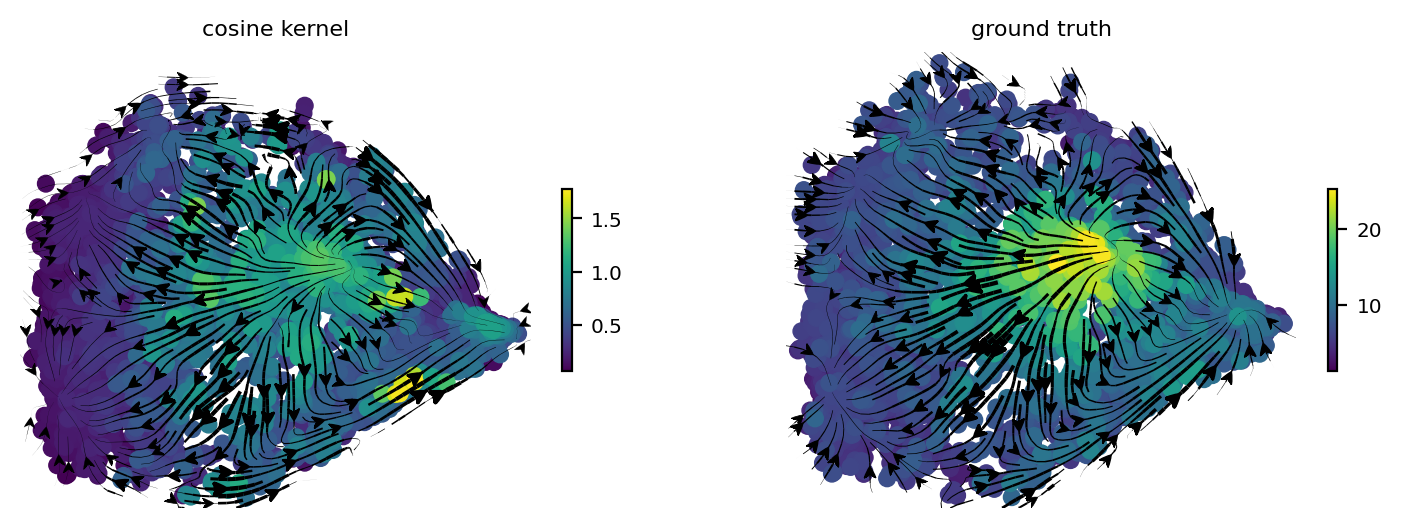

In [13]:
plt.figure(figsize=(9, 3))

plt.subplot(121)
dyn.pl.zscatter(adata, basis='pca', color='velocity_cos_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca', v_basis='cos_pca')
plt.title('cosine kernel')

plt.subplot(122)
dyn.pl.zscatter(adata, basis='pca', color='velocity_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca')
plt.title('ground truth')

#plt.savefig('neurogenesis_cos_vel.pdf')

# Coopt discrete vector field

In [14]:
X.shape, V.shape, nbrs_idx.shape, type(X), type(V), type(nbrs_idx)

((5000, 12),
 (5000, 12),
 (5000, 200),
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

In [15]:
from scipy.sparse import csr_matrix

In [16]:
normalize_difference = False
F = graphize_velocity_coopt(X, V, P_dc, nbrs_idx, b=50.0, norm_dist=normalize_difference)
gvf = dyn.tl.GraphVectorField(F, E=adata.obsp['distances'].A)

In [17]:
adata.obsm['velocity_coopt'] = gvf.project_velocity(X, norm_dist=normalize_difference)
adata.obs['velocity_coopt'] = np.linalg.norm(adata.obsm['velocity_coopt'], axis=1)

|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5954s]


In [18]:
adata.obs['velocity_raw'] = np.linalg.norm(adata.obsm['velocity_raw'], axis=1)

Text(0.5, 1.0, 'ground truth')

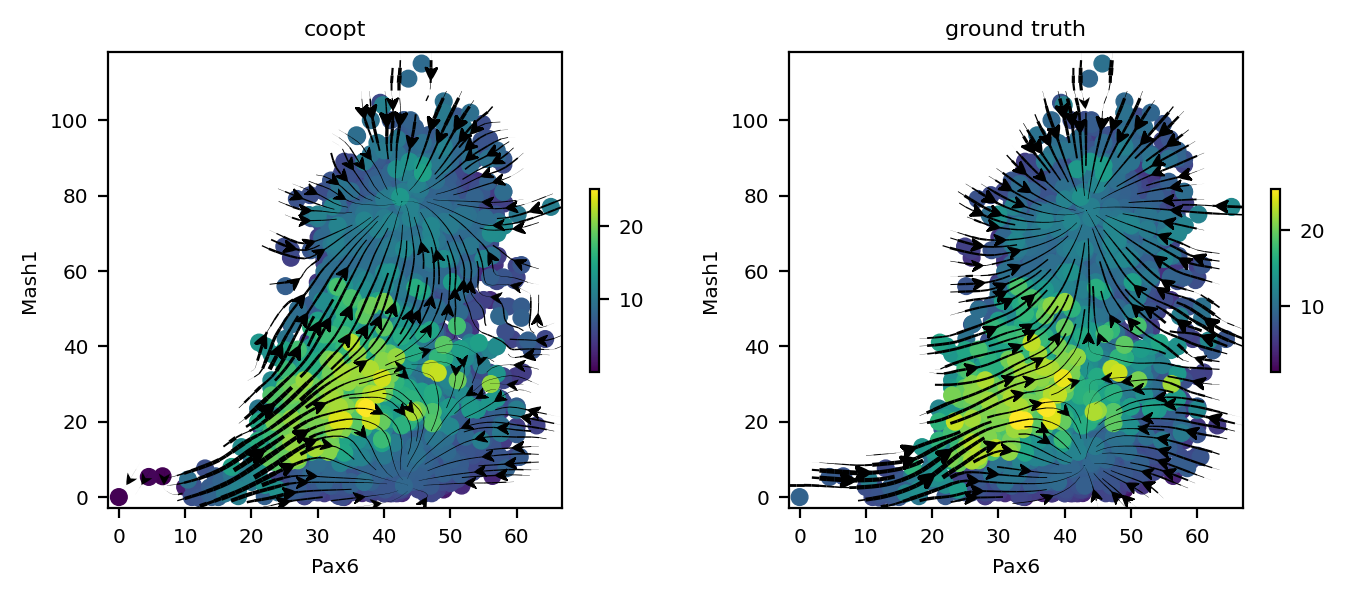

In [19]:
genes = ['Pax6', 'Mash1']
dims = [np.where(adata.var.index==g)[0][0] for g in genes]

plt.figure(figsize=(8, 3))

plt.subplot(121)
dyn.pl.zscatter(adata, basis='raw', color='velocity_coopt', cmap='viridis', dims=dims, axis_off=False)
dyn.pl.zstreamline(adata, basis='raw', v_basis='coopt', dims=dims)
plt.xlabel(genes[0])
plt.ylabel(genes[1])
plt.title('coopt')

plt.subplot(122)
dyn.pl.zscatter(adata, basis='raw', color='velocity_raw', cmap='viridis', dims=dims, axis_off=False)
dyn.pl.zstreamline(adata, basis='raw', dims=dims)
plt.xlabel(genes[0])
plt.ylabel(genes[1])
plt.title('ground truth')

#plt.savefig(f'neurogenesis_coopt_vel_{genes[0]}_{genes[1]}.pdf')

In [20]:
adata.obsm['velocity_coopt_pca'] = gvf.project_velocity(X_emb, norm_dist=normalize_difference)
adata.obs['velocity_coopt_pca'] = np.linalg.norm(adata.obsm['velocity_coopt_pca'], axis=1)

|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6360s]


Text(0.5, 1.0, 'ground truth')

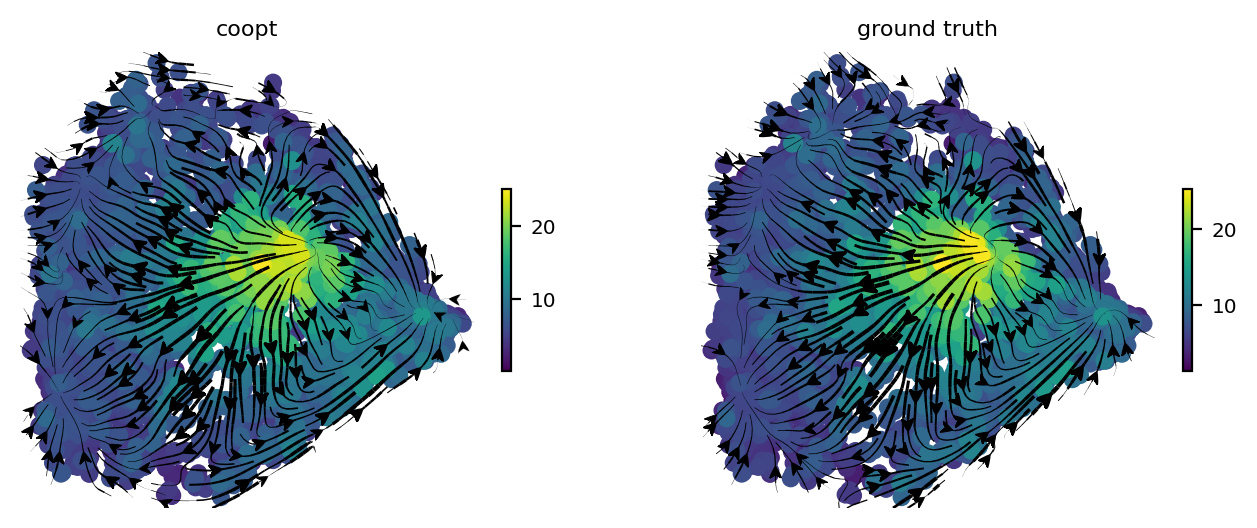

In [21]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
dyn.pl.zscatter(adata, basis='pca', color='velocity_coopt_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca', v_basis='coopt_pca')
plt.title('coopt')

plt.subplot(122)
dyn.pl.zscatter(adata, basis='pca', color='velocity_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca')
plt.title('ground truth')

#plt.savefig('neurogenesis_coopt_vel.pdf')

In [22]:
sim_cos = np.diag(cosine_similarity(adata.obsm['velocity_cos'], adata.obsm['velocity_raw']))
sim_coopt = np.diag(cosine_similarity(adata.obsm['velocity_coopt'], adata.obsm['velocity_raw']))
diff_cos = np.linalg.norm(adata.obsm['velocity_cos'] - adata.obsm['velocity_raw'], axis=1)
diff_coopt = np.linalg.norm(adata.obsm['velocity_coopt'] - adata.obsm['velocity_raw'], axis=1)

Text(0.5, 1.0, 'residual norm')

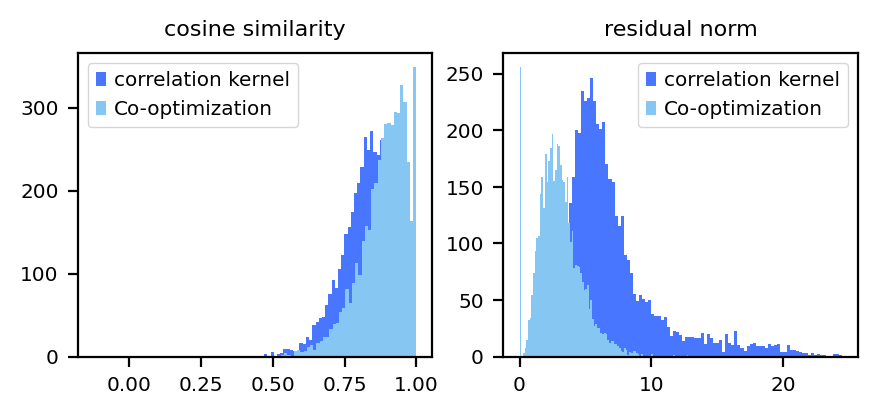

In [23]:
plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.hist(sim_cos, 100)
plt.hist(sim_coopt, 100)
plt.legend(['correlation kernel', 'Co-optimization'])
plt.title('cosine similarity')

plt.subplot(122)
plt.hist(diff_cos, 100)
plt.hist(diff_coopt, 100)
plt.legend(['correlation kernel', 'Co-optimization'])
plt.title('residual norm')

#plt.savefig('neurogenesis_hist.pdf')

# Graph Calculus

In [24]:
adata.obs['divergence_graph'] = gvf.divergence()
adata.obs['potential_graph'] = gvf.potential()

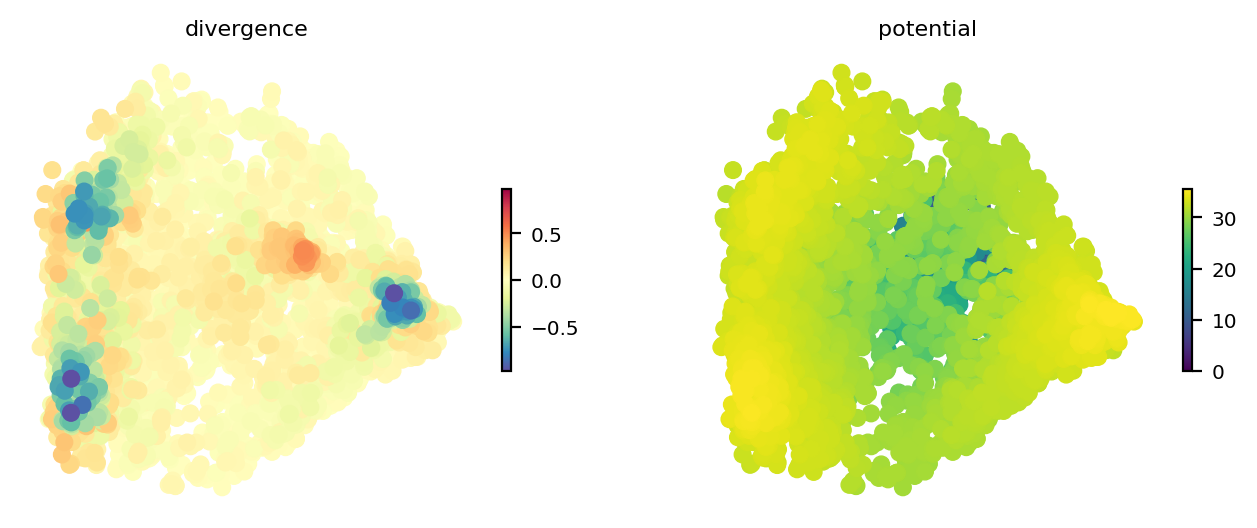

In [25]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
dyn.pl.zscatter(adata, basis='pca', color='divergence_graph', **dyn.pl.SchemeDiverge)
plt.title('divergence')

plt.subplot(122)
dyn.pl.zscatter(adata, basis='pca', color='potential_graph', cmap='viridis')
plt.title('potential')

plt.savefig('neurogenesis_pot_div.pdf')

In [26]:
gvf_pot = dyn.tl.GraphVectorField(gradient(gvf.E, adata.obs['potential_graph']))

adata.obsm['velocity_grad_pca'] = gvf_pot.project_velocity(X_emb, norm_dist=normalize_difference)
adata.obs['velocity_grad_pca'] = np.linalg.norm(adata.obsm['velocity_grad_pca'], axis=1)

|-----> Neither edge weight nor length matrix is provided. Inferring adjacency matrix from `F`.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6399s]


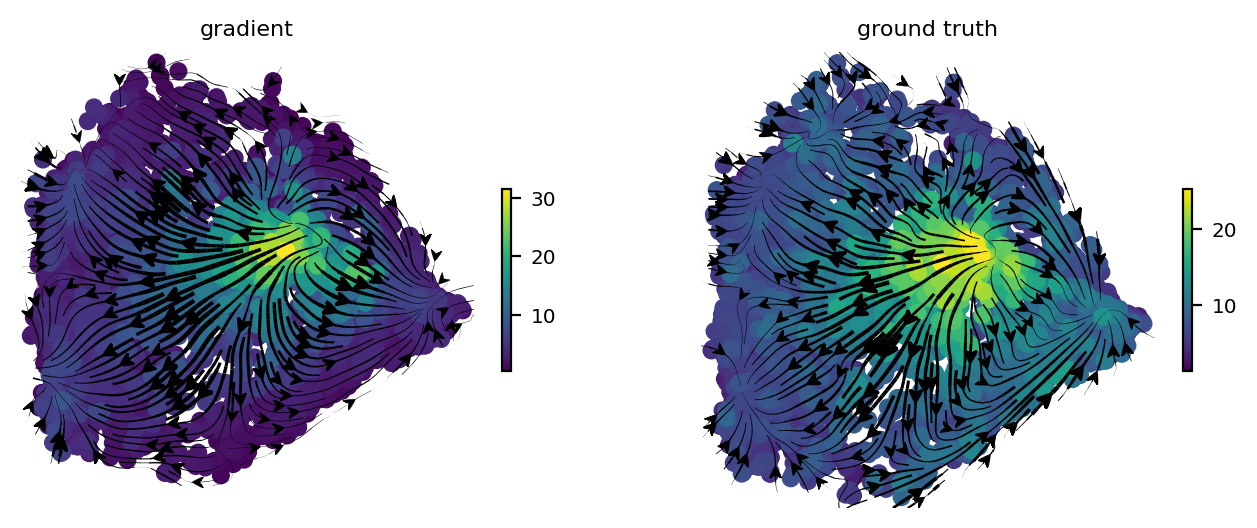

In [27]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
dyn.pl.zscatter(adata, basis='pca', color='velocity_grad_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca', v_basis='grad_pca')
plt.title('gradient')

plt.subplot(122)
dyn.pl.zscatter(adata, basis='pca', color='velocity_pca', cmap='viridis')
dyn.pl.zstreamline(adata, basis='pca')
plt.title('ground truth')

plt.savefig('neurogenesis_grad_vel.pdf')

In [28]:
sim_grad = np.diag(cosine_similarity(adata.obsm['velocity_grad_pca'], adata.obsm['velocity_pca']))
diff_grad = np.linalg.norm(adata.obsm['velocity_grad_pca'] - adata.obsm['velocity_pca'], axis=1)

Text(0.5, 1.0, 'residual norm')

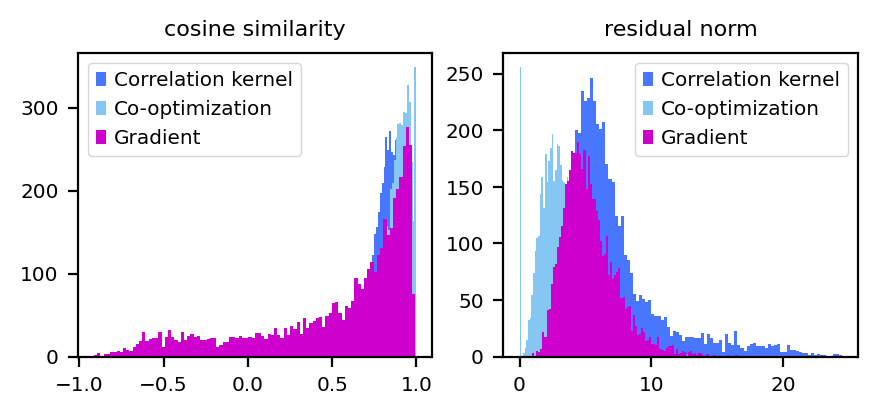

In [29]:
plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.hist(sim_cos, 100)
plt.hist(sim_coopt, 100)
plt.hist(sim_grad, 100)
plt.legend(['Correlation kernel', 'Co-optimization', 'Gradient'])
plt.title('cosine similarity')

plt.subplot(122)
plt.hist(diff_cos, 100)
plt.hist(diff_coopt, 100)
plt.hist(diff_grad, 100)
plt.legend(['Correlation kernel', 'Co-optimization', 'Gradient'])
plt.title('residual norm')

#plt.savefig('neurogenesis_hist.pdf')

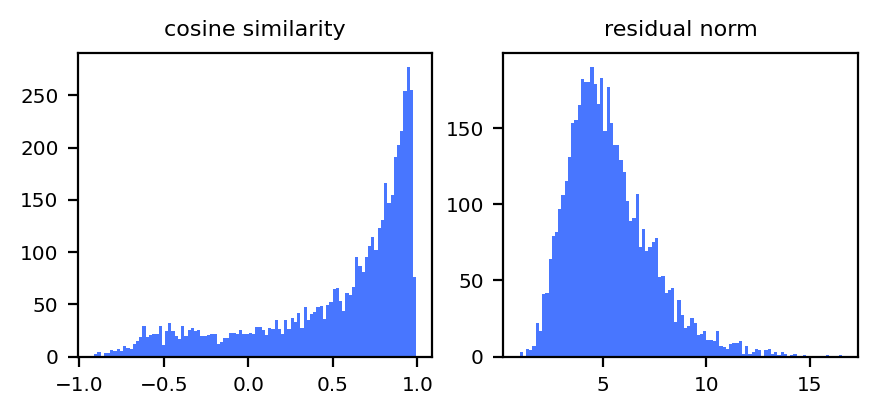

In [30]:
plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.hist(sim_grad, 100)
plt.title('cosine similarity')

plt.subplot(122)
plt.hist(diff_grad, 100)
plt.title('residual norm')

plt.savefig('neurogenesis_hist_grad.pdf')

# FP operator and CTMC propagation

In [31]:
Q = gvf.fp_operator(D=1.0)
ctmc = dyn.tl.ContinuousTimeMarkovChain(Q)

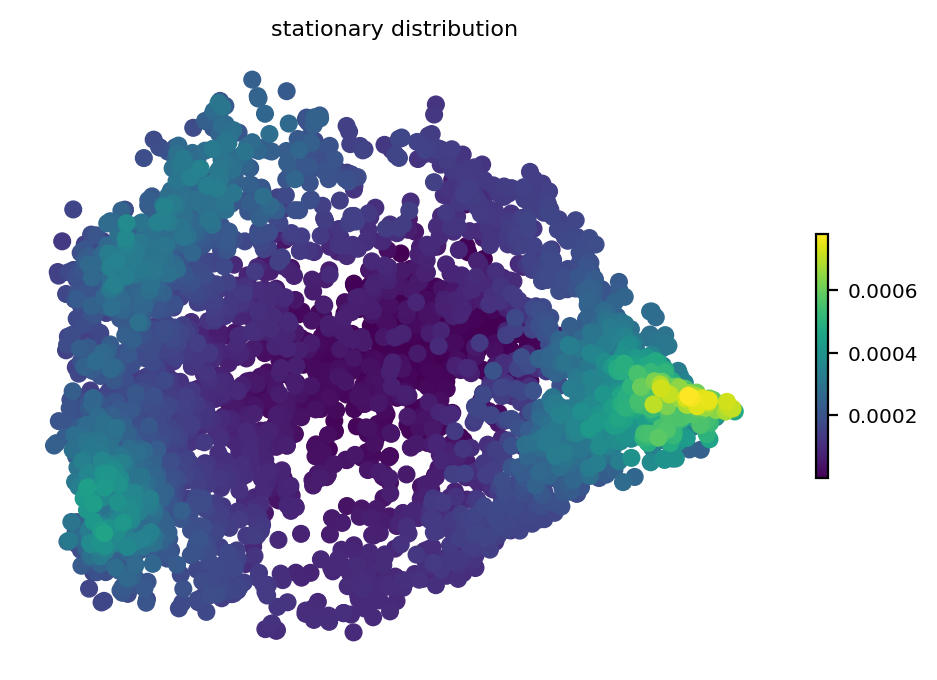

In [32]:
if not skip_stationary_distribution:
    p_st = ctmc.compute_stationary_distribution()
    dyn.pl.zscatter(adata, basis='pca', color=p_st, cmap='viridis'),
    plt.title('stationary distribution')
    
    plt.savefig('neurogenesis_pst.pdf')

## Propagation of probability distribution using CTMC

In [33]:
cell_init = dyn.tl.select(adata.obs, dyn.tl.AnnDataPredicate('time', 1, op='<'))
p0 = ctmc.make_p0(cell_init)

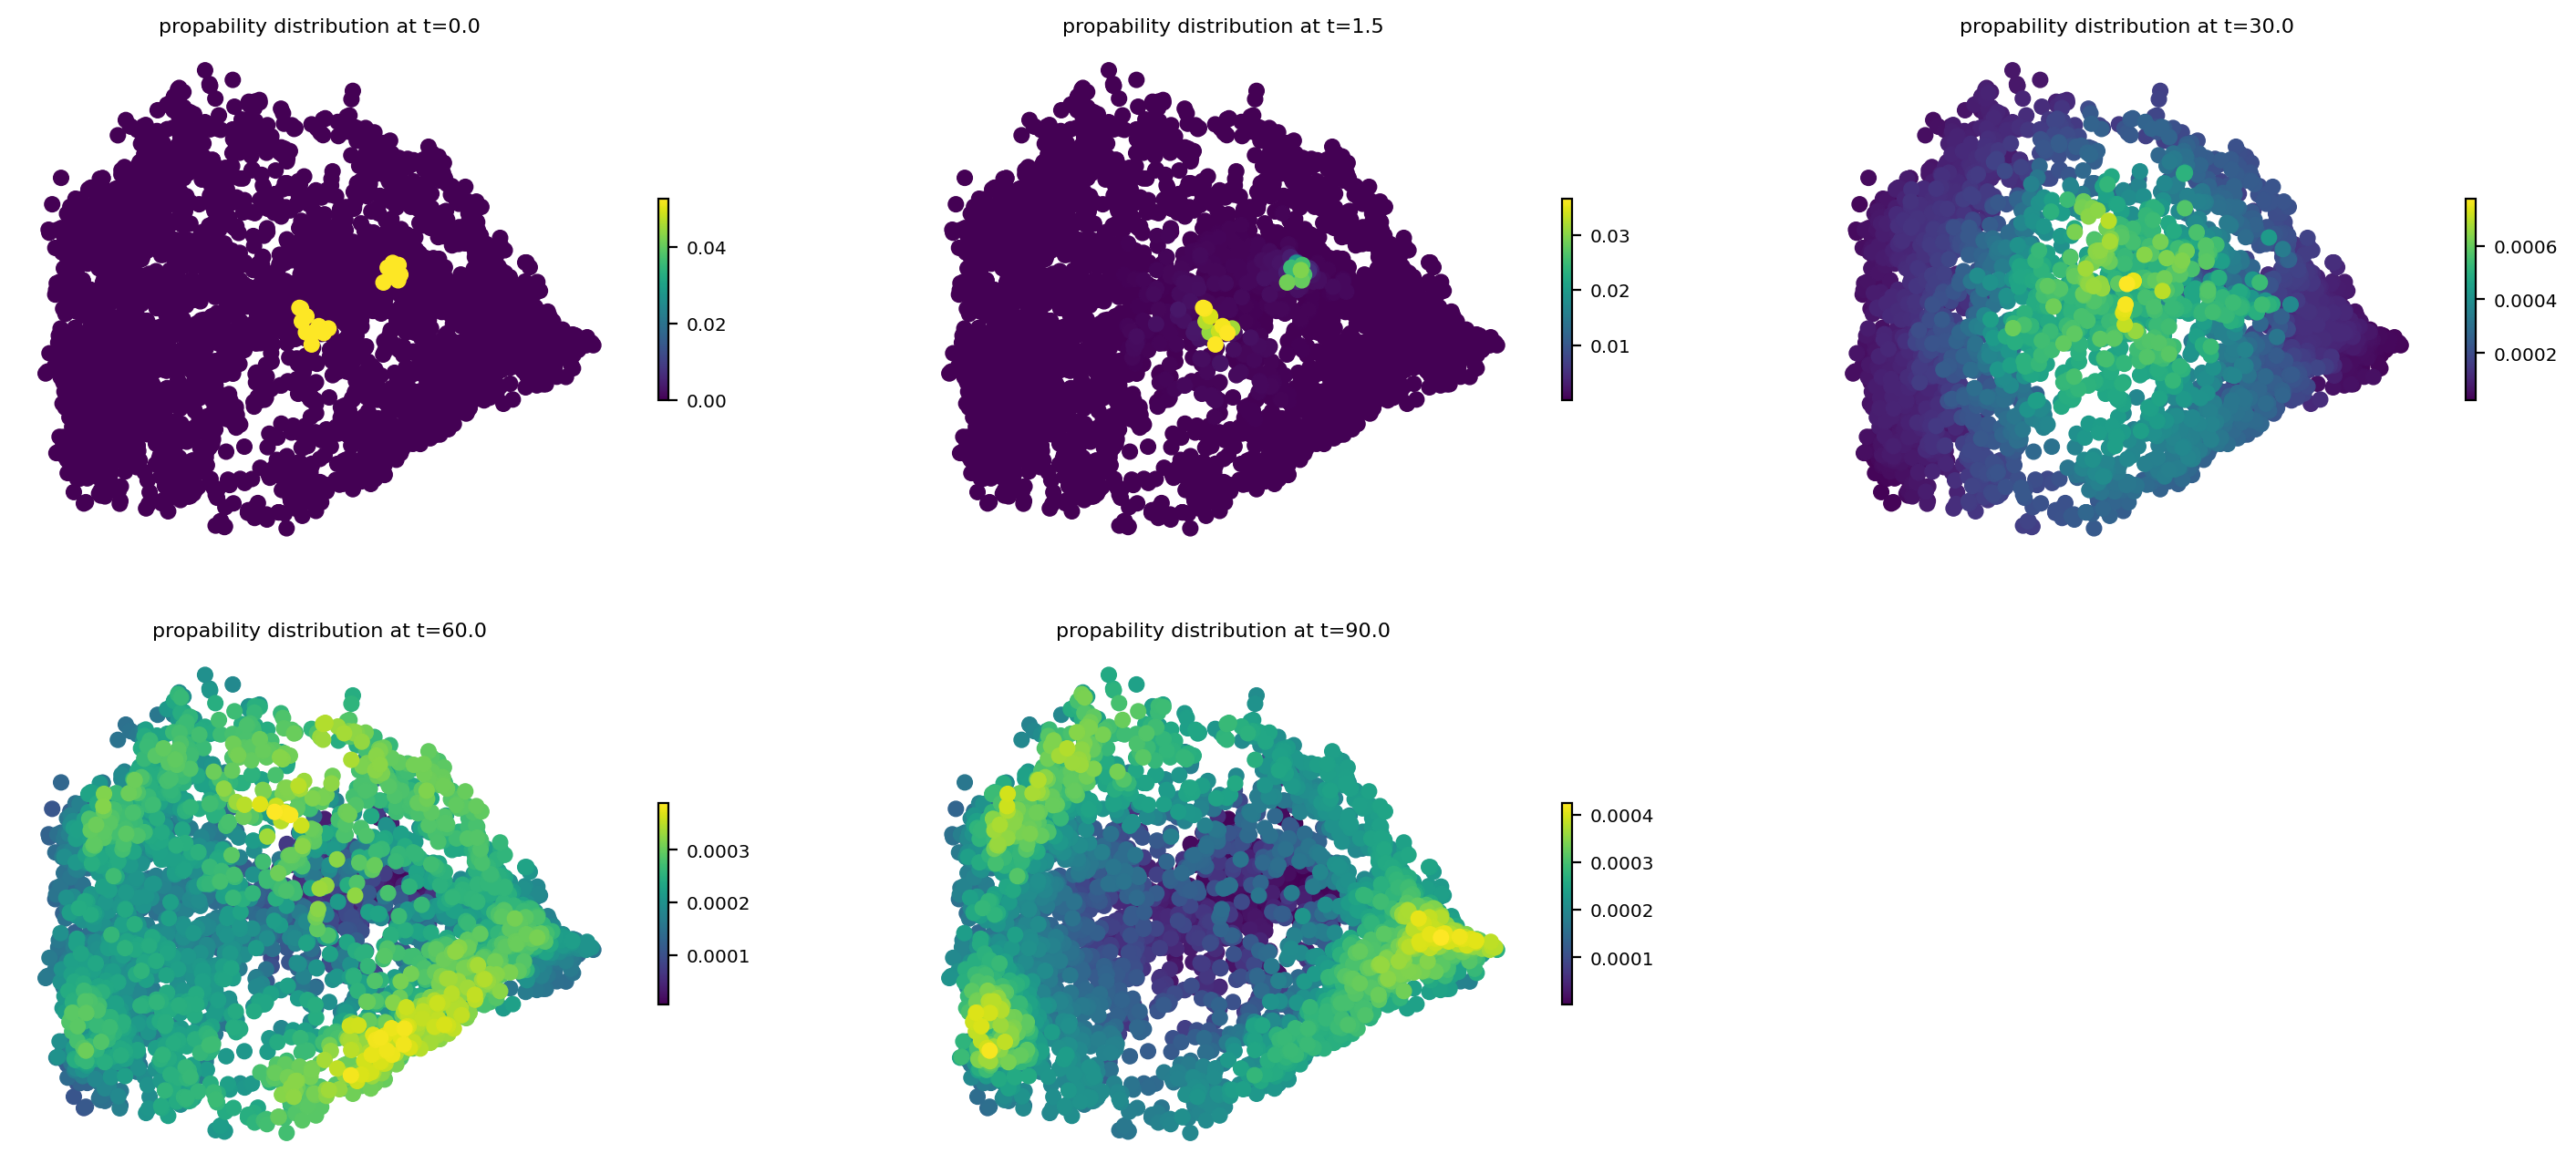

In [34]:
if not skip_propagation:
    dyn.pl.multiplot(lambda t: [
        dyn.pl.zscatter(adata, basis='pca', color=ctmc.compute_transition_matrix(t=t) @ p0, cmap='viridis'),
        plt.title(f'propability distribution at t={t}')
    ], np.array([0, 0.5, 10.0, 20.0, 30.0])*3)
    
plt.savefig('neurogenesis_propagation.pdf')

[<AxesSubplot: title={'center': 'cells whose -10<t<0'}>,
 <AxesSubplot: title={'center': 'cells whose -9.5<t<0.5'}>,
 <AxesSubplot: title={'center': 'cells whose 0.0<t<10.0'}>,
 <AxesSubplot: title={'center': 'cells whose 10.0<t<20.0'}>,
 <AxesSubplot: title={'center': 'cells whose 20.0<t<30.0'}>]

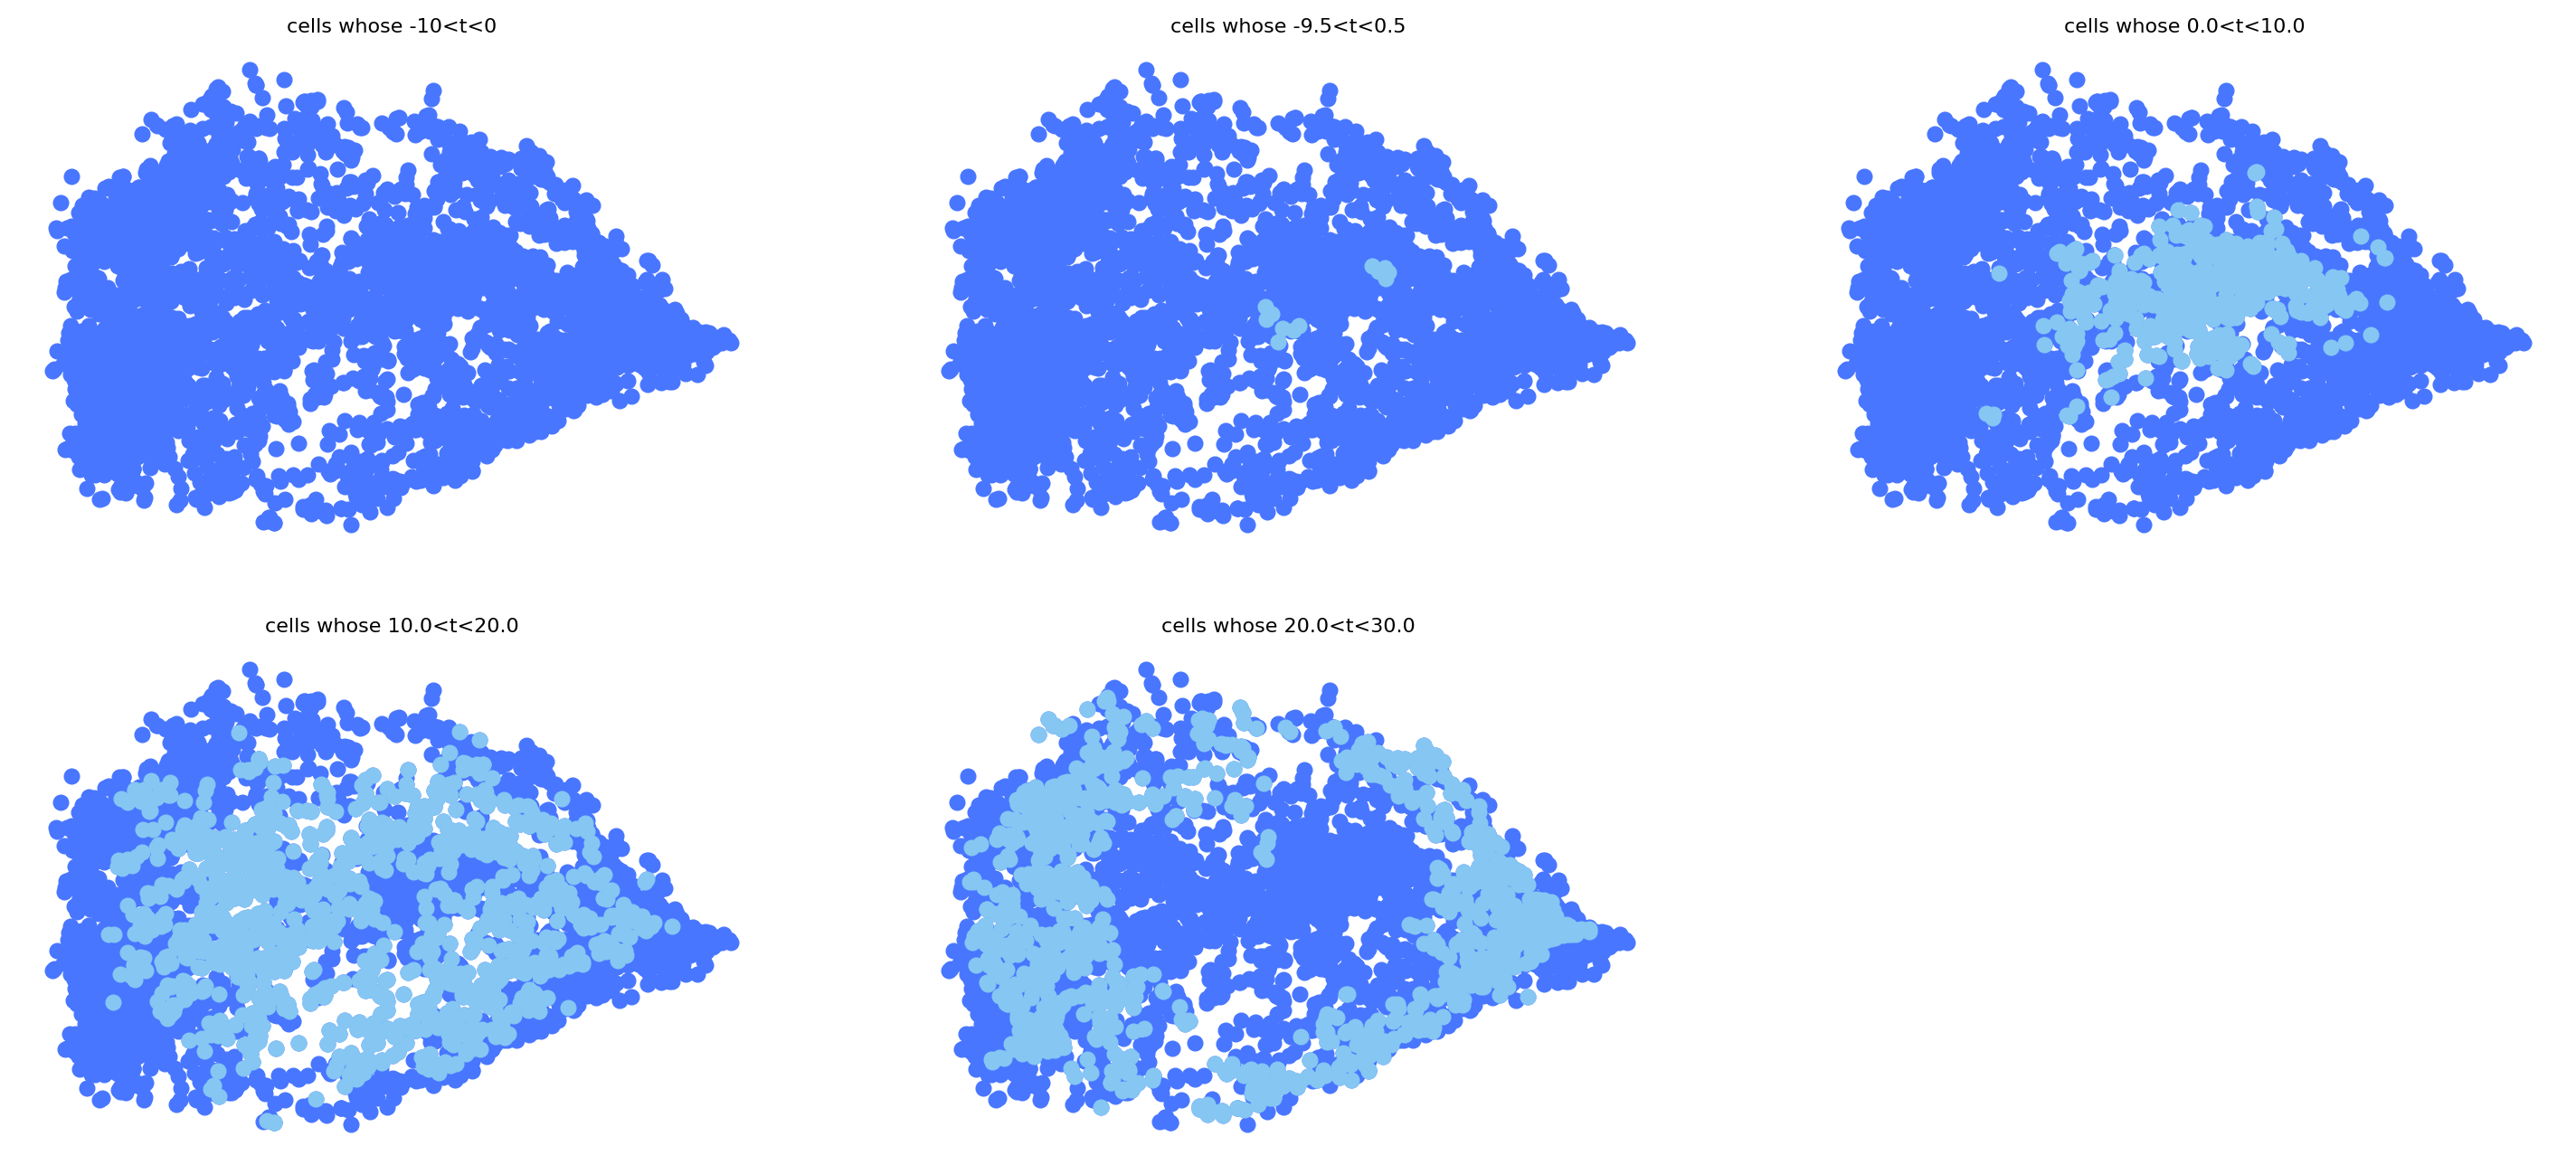

In [35]:
select_func = lambda t: dyn.tl.select(adata.obs, dyn.tl.AnnDataPredicate('time', t, op='<')&dyn.tl.AnnDataPredicate('time', t-10, op='>'))

dyn.pl.multiplot(lambda t: [
    dyn.pl.zscatter(adata, basis='pca'),
    dyn.pl.plot_X(X_emb[select_func(t)]),
    plt.title(f'cells whose {t-10}<t<{t}')
], [0, 0.5, 10.0, 20.0, 30.0])

In [36]:
neuron = dyn.tl.select_cell(adata, 'cell_type', 'neuron')
astro = dyn.tl.select_cell(adata, 'cell_type', 'astrocyte')
oligo = dyn.tl.select_cell(adata, 'cell_type', 'oligodendr')

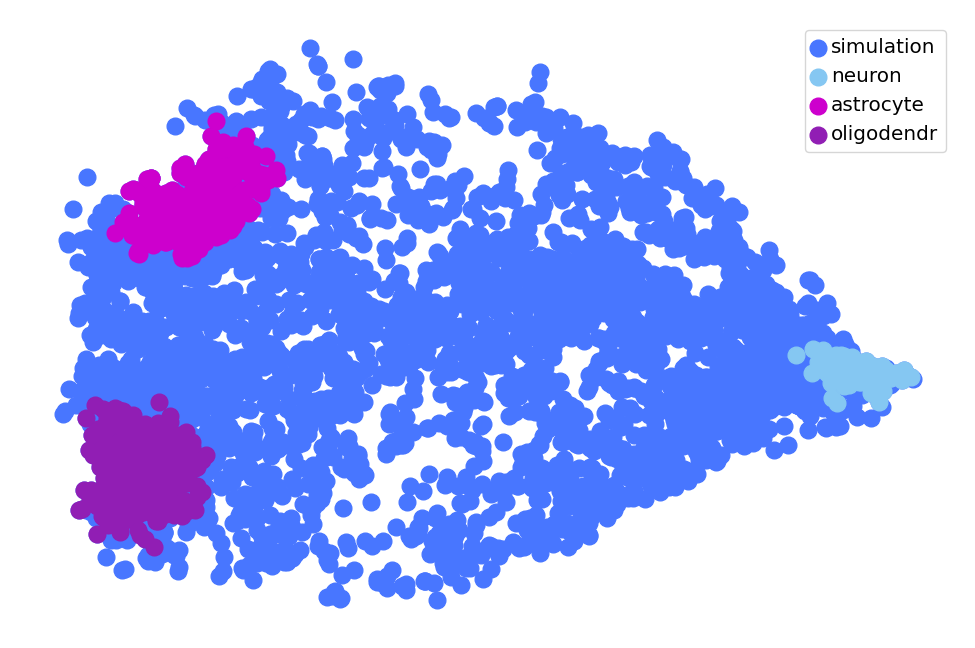

In [37]:
dyn.pl.zscatter(adata, basis='pca')
dyn.pl.plot_X(X_emb[neuron])
dyn.pl.plot_X(X_emb[astro])
dyn.pl.plot_X(X_emb[oligo])
plt.legend(['simulation', 'neuron', 'astrocyte', 'oligodendr'])

In [38]:
MET = ctmc.compute_mean_exit_time(p0, np.hstack((neuron, astro, oligo)))
print('mean exit time: %f'%MET)

mean exit time: 119.962824


In [39]:
MFPT_neuron = ctmc.compute_mean_first_passage_time(p0, target=neuron, sinks=np.hstack((astro, oligo)))
print('mean first passage time for neuron: %f'%MFPT_neuron)

mean first passage time for neuron: 180.572416


In [40]:
MFPT_astro = ctmc.compute_mean_first_passage_time(p0, target=astro, sinks=np.hstack((neuron, oligo)))
print('mean first passage time for astrocyte: %f'%MFPT_astro)

mean first passage time for astrocyte: 77.386954


In [41]:
MFPT_oligo = ctmc.compute_mean_first_passage_time(p0, target=oligo, sinks=np.hstack((neuron, astro)))
print('mean first passage time for oligodendrocyte: %f'%MFPT_oligo)

mean first passage time for oligodendrocyte: 72.580069


[<AxesSubplot: title={'center': 'cells whose 99.96282390513008<t<109.96282390513008'}>,
 <AxesSubplot: title={'center': 'cells whose 109.96282390513008<t<119.96282390513008'}>,
 <AxesSubplot: title={'center': 'cells whose 119.96282390513008<t<129.96282390513008'}>]

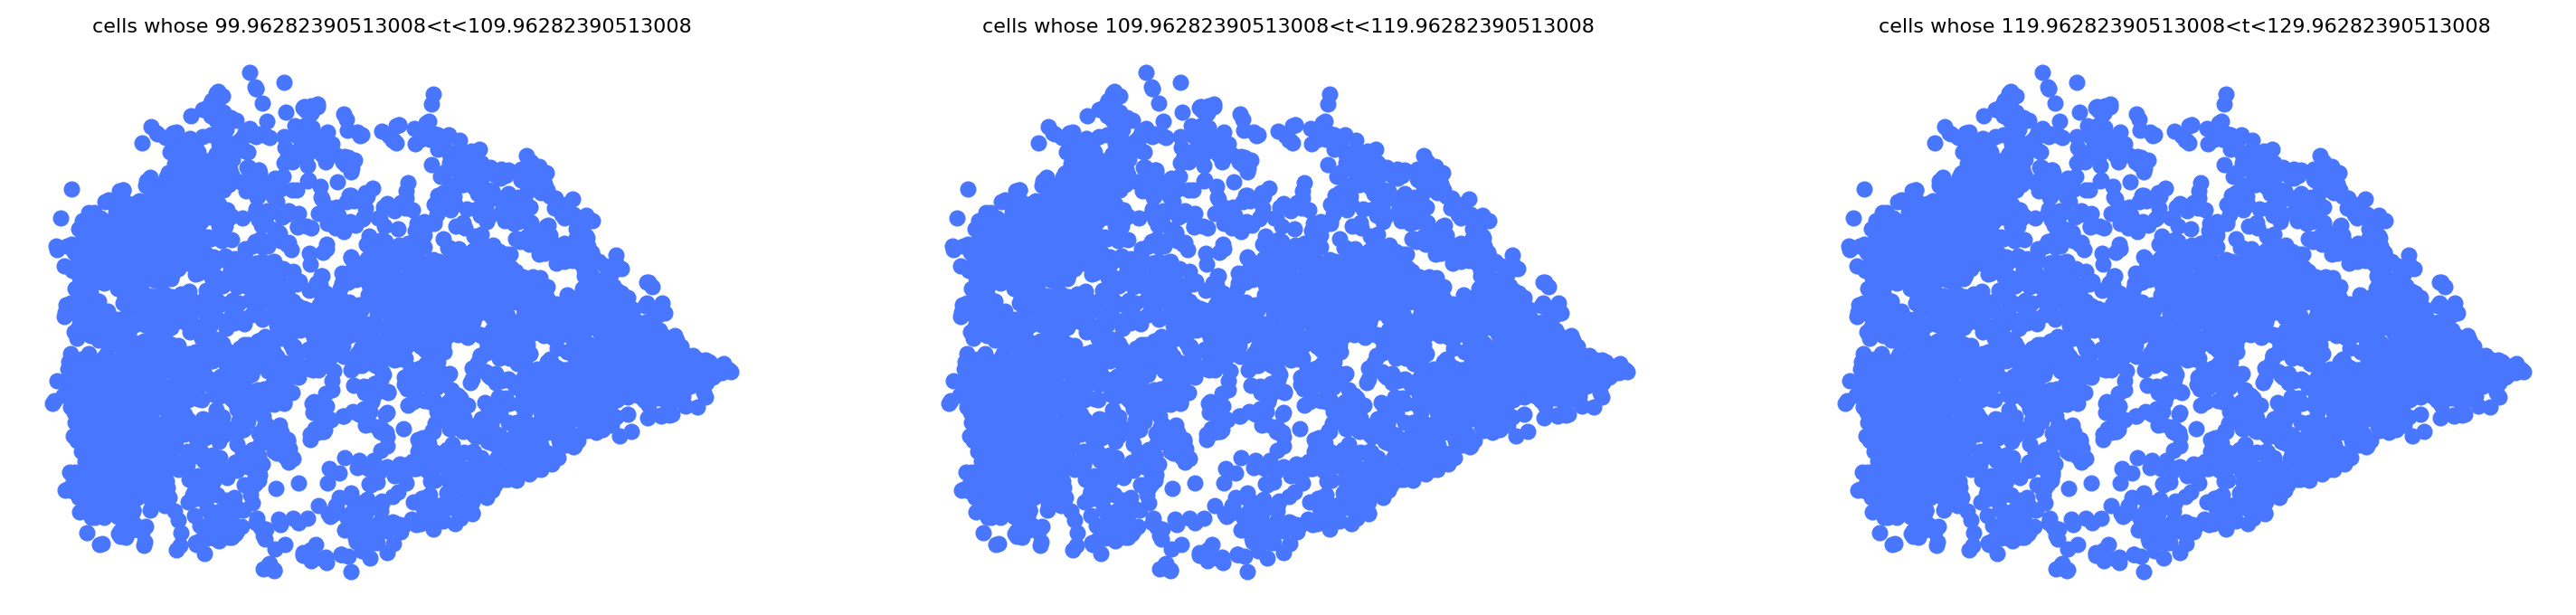

In [42]:
select_func = lambda t: dyn.tl.select(adata.obs, dyn.tl.AnnDataPredicate('time', t, op='<')&dyn.tl.AnnDataPredicate('time', t-10, op='>'))

dyn.pl.multiplot(lambda t: [
    dyn.pl.zscatter(adata, basis='pca'),
    dyn.pl.plot_X(X_emb[select_func(t)]),
    plt.title(f'cells whose {t-10}<t<{t}')
], [MET - 10, MET, MET + 10])

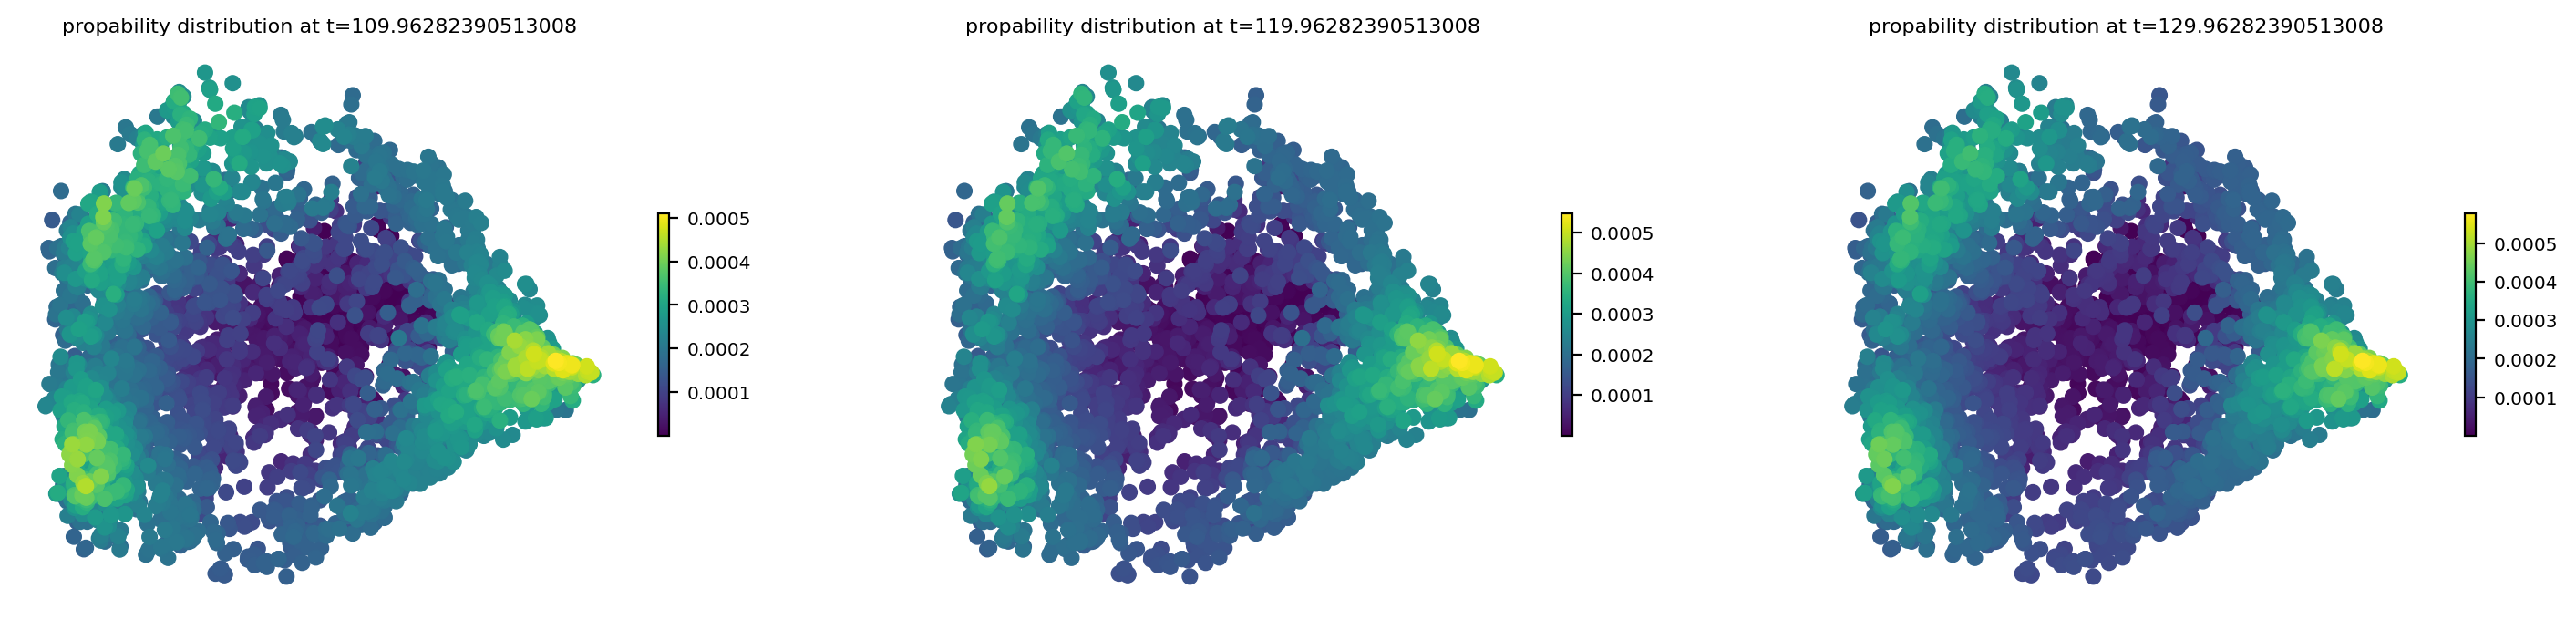

In [43]:
if not skip_propagation:
    dyn.pl.multiplot(lambda t: [
        dyn.pl.zscatter(adata, basis='pca', color=ctmc.compute_transition_matrix(t=t) @ p0, cmap='viridis'),
        plt.title(f'propability distribution at t={t}')
    ], [MET - 10, MET, MET + 10])

# Calculate mean exit time from Gillespie trajectories

In [44]:
met_trajs = dyn.pd.mean_first_passage_time(adata, xkey='total', sink_states=np.hstack((neuron, astro, oligo)))
print("mean exit time: %f"%met_trajs)

|-----> No target states is provided. Calculating mean exit time...
mean exit time: 28.472325


In [45]:
mfpt_neuron_trajs = dyn.pd.mean_first_passage_time(adata, xkey='total', target_states=neuron, sink_states=np.hstack((astro, oligo)))
print("mean first passage time for neuron: %f"%mfpt_neuron_trajs)

|-----> Calculating mean first passage time to the target states...
mean first passage time for neuron: 39.621422


In [46]:
mfpt_astro_trajs = dyn.pd.mean_first_passage_time(adata, xkey='total', target_states=astro, sink_states=np.hstack((neuron, oligo)))
print("mean first passage time for astrocyte: %f"%mfpt_astro_trajs)

|-----> Calculating mean first passage time to the target states...
mean first passage time for astrocyte: 24.113443


In [47]:
mfpt_oligo_trajs = dyn.pd.mean_first_passage_time(adata, xkey='total', target_states=oligo, sink_states=np.hstack((neuron, astro)))
print("mean first passage time for oligodendrocyte: %f"%mfpt_oligo_trajs)

|-----> Calculating mean first passage time to the target states...
mean first passage time for oligodendrocyte: 28.346379


[<AxesSubplot: title={'center': 'cells whose 8.47<t<18.47'}>,
 <AxesSubplot: title={'center': 'cells whose 18.47<t<28.47'}>,
 <AxesSubplot: title={'center': 'cells whose 28.47<t<38.47'}>]

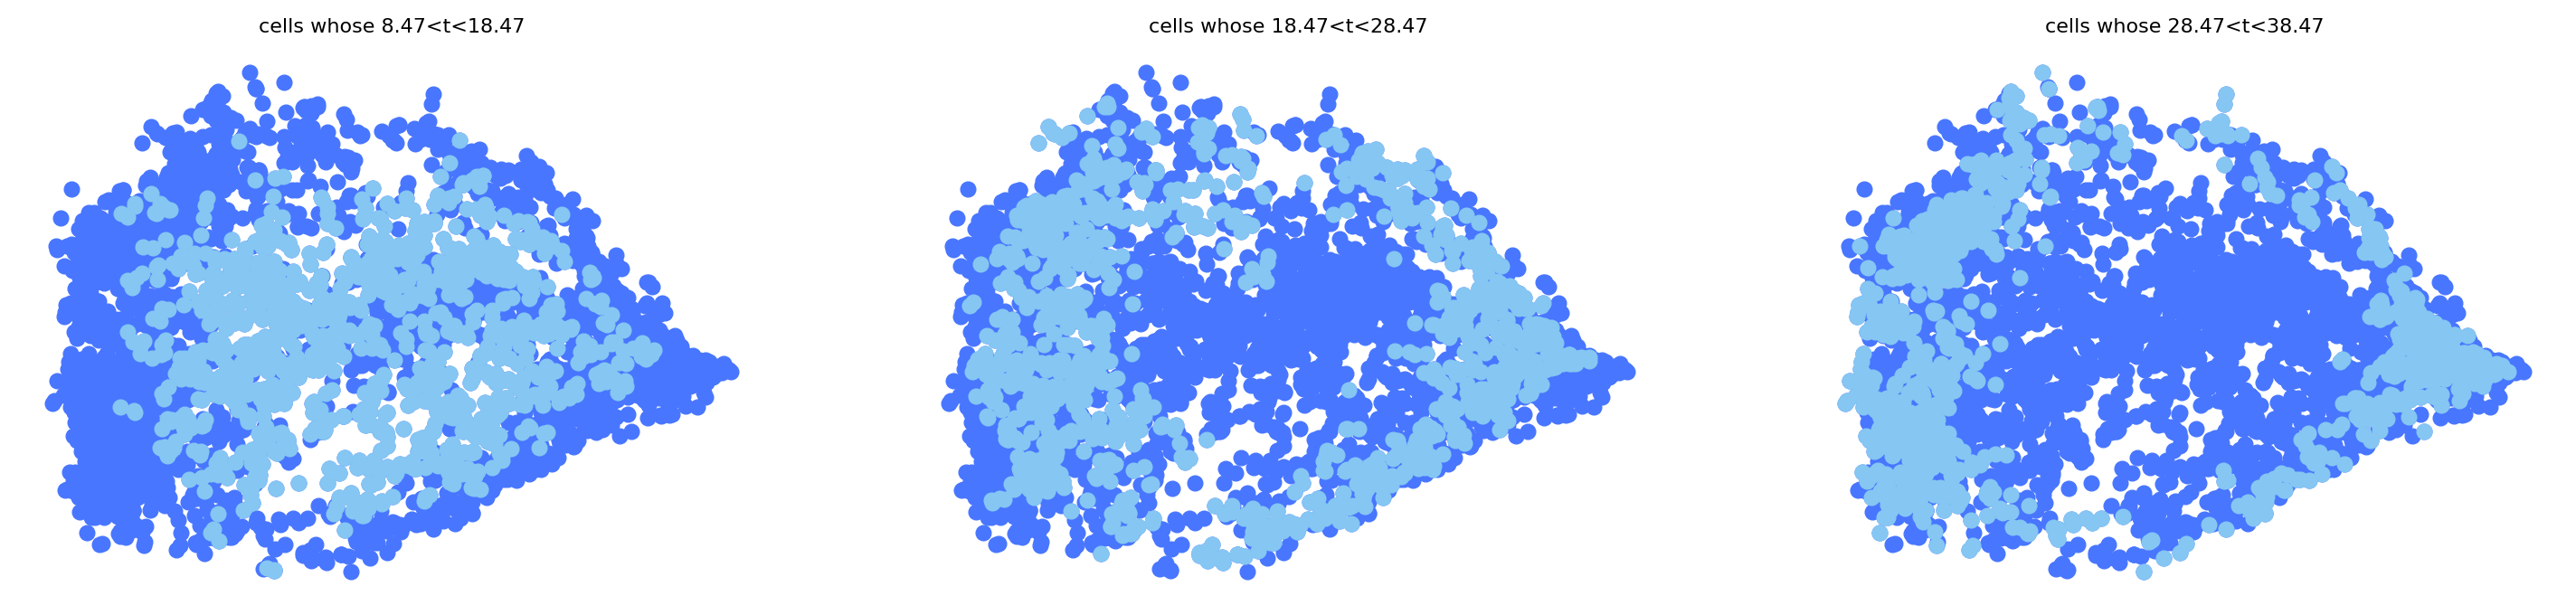

In [48]:
select_func = lambda t: dyn.tl.select(adata.obs, dyn.tl.AnnDataPredicate('time', t, op='<')&dyn.tl.AnnDataPredicate('time', t-10, op='>'))

dyn.pl.multiplot(lambda t: [
    dyn.pl.zscatter(adata, basis='pca'),
    dyn.pl.plot_X(X_emb[select_func(t)]),
    plt.title('cells whose %.2f<t<%.2f'%(t-10, t))
], [met_trajs - 10, met_trajs, met_trajs + 10])